In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math

from torch.utils.data import DataLoader

import torch
import torch.nn as nn

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
src_domain = 'FSeg'
tgt_domain = 'SubF3'

da_method = 'FDA'
Lb = 0.1
fda_imgs = 1024

# data
red = 0 # reduction factor
n_imgs = 16000  # {3200, 6400} max: 51200
bs = 32 # batch size
type_aug = 'type1_fda' # type0, type1
nw = 2 # num_workers

# model
net = "dexined" # unet2d / dexined
f = 16 # filters on first layer

# training
optimizer = 'Adam'
lr = 1e-4
lr_adjust = False
epochs = 10 # 100
loss = 'BCE'

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [4]:
from dataloaders import F3Generator , FaultSeg2DGenerator
from torch.utils.data import DataLoader

In [6]:
dataset = 'SubF3'
DATAPATH = os.path.join(DATAFOLDER, dataset)

DATAPATH_F3 = os.path.join(DATAPATH, 'Patches2D')

gen_F3 = F3Generator(DATAPATH_F3, red=red, n_imgs=n_imgs) #, aug="type1")
len(gen_F3.list_IDs) # 5248

5248

In [8]:
# extract references images from target domain
ref_imgs=[]
for idx, x in enumerate(gen_F3):
    ref_imgs.append(x[0])
    if idx == fda_imgs:
        break

In [10]:
dataset = 'FaultSeg3D'
DATAPATH_FS = os.path.join(DATAFOLDER, dataset)

train_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "train", red=red, n_imgs=n_imgs, aug=type_aug,
                                  ref_imgs=ref_imgs, Lb=Lb)
val_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "val", red=red, n_imgs=n_imgs)
len(train_gen_FS.list_IDs) # 51200

16000

In [11]:
tr_vl_tgt = DataLoader(dataset=gen_F3, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)

train_src = DataLoader(dataset=train_gen_FS, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_src = DataLoader(dataset=val_gen_FS, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

## Modeling

In [13]:
from models.dexined import DexiNed
from loss import bdcn_loss2

model = DexiNed(f1=f).to(device)

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=lr)

criterion = bdcn_loss2

## Training

In [15]:
from metrics import *

In [16]:
# saved_name = wandb.run.id
# saved_path = os.path.join(PATH, 'res', '{}.pt'.format(saved_name))
# wandb.config.update({"saved_path": saved_name})

saved_path = "delete.pt"

stopPatience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=stopPatience//2, verbose=True)
saved_path

'delete.pt'

In [17]:
def process(load_src, model, phase='train', opt=None, epoch=0):

    task_loss_ = 0.0
    
    iou_ = 0.0
    
    if phase=='train':
        model.train()  
    else:
        model.eval()
        
    epoch += 1
    
    if phase=='train':
        model.train() 
        if lr_adjust:
            for param_group in opt.param_groups:
                param_group['lr'] = lr / math.pow((1 + 10 * (epoch - 1) / epochs), 0.75)
    else:
        model.eval()
    
    
    for step_, (x_src, y_src) in enumerate(load_src):
        
        # make images variable
        x_src = x_src.float().to(device=device)
        y_src = y_src.to(device=device).unsqueeze(1)
        
        # source domain
        src_task_outs = model(x_src)
        
        probs = (src_task_outs[-1] + src_task_outs[2] + src_task_outs[3])/3.
        src_loss_class = criterion(src_task_outs[-1], y_src, 0.5) + criterion(src_task_outs[2], y_src, 0.5) # bdcn_loss
        src_loss_class = src_loss_class / 5. # just to keep in a similar range than BCE
                
        if phase=='train':
            # calculate the gradients
            opt.zero_grad()
            src_loss_class.backward()

            # update weigths
            opt.step()
        
        ## compute loss
        task_loss_ += src_loss_class.item()
        
        ## compute metrics
        task_output = torch.nn.Sigmoid()(probs)
        pred_ = (task_output > 0.5).float() 
        iou_ += compute_iou(y_src.squeeze(1), pred_.squeeze(1))
             
    task_loss = task_loss_/(step_+1)
    iou = iou_/(step_+1)
    
    if phase=='val':
        scheduler.step(task_loss)
        
    return task_loss, iou

In [18]:
min_valid_loss = np.inf
max_valid_vl = -np.inf
n_patience = 0
t_start = time.time()
t_start_total = time.time()

for ep in range(epochs):
    
    task_loss_tr, iou_src_tr = process(train_src, model, phase='train', opt=opt, epoch=ep)

    with torch.no_grad():
        task_loss_vl, iou_src_vl = process(val_src, model, phase='val', epoch=ep)
        
    t_ = time.time()-t_start

    for param_group in opt.param_groups:
        lr_step = param_group['lr']
    
    # wandb.log({
    #     "train/epoch/time": t_,
    #     "train/epoch/step": ep+1,
    #     "lr/step": lr_step,
        
    #     "train/epoch/task_loss": task_loss_tr,
    #     "train/epoch/iou/src": iou_src_tr,
        
    #     "val/epoch/task_loss": task_loss_vl,
    #     "val/epoch/iou/src": iou_src_vl,

    # })
    

    print('Epoch {}:   {:.1f}s - loss: {:.4f} - iou_src: {:.4f}'.format(ep+1, t_, task_loss_tr, iou_src_tr))
    print('                   val_loss: {:.4f} - val_iou_src: {:.4f}'.format(task_loss_vl, iou_src_vl))
#     print('')

    loss_vl = task_loss_vl
    
    if min_valid_loss > loss_vl:
        print(f'val_loss improved from {min_valid_loss:.6f} to {loss_vl:.6f} , saving model\n')
        min_valid_loss = loss_vl
        torch.save(model.state_dict(), saved_path)
        n_patience=0
    else:
        print(f'val_loss did not improve from {min_valid_loss:.6f}\n')
        n_patience+=1
        if n_patience==stopPatience:
            print('Epoch {}:   early stopping'.format(ep+1))
            break
            
    t_start = time.time()
    
t_total = time.time() - t_start_total

Epoch 1:   140.8s - loss: 0.5369 - iou_src: 0.1718
                   val_loss: 0.5122 - val_iou_src: 0.2453
val_loss improved from inf to 0.512219 , saving model

Epoch 2:   141.7s - loss: 0.4619 - iou_src: 0.2873
                   val_loss: 0.4741 - val_iou_src: 0.3016
val_loss improved from 0.512219 to 0.474052 , saving model

Epoch 3:   149.9s - loss: 0.4310 - iou_src: 0.3290
                   val_loss: 0.4515 - val_iou_src: 0.3370
val_loss improved from 0.474052 to 0.451451 , saving model

Epoch 4:   152.1s - loss: 0.4113 - iou_src: 0.3526
                   val_loss: 0.4299 - val_iou_src: 0.3716
val_loss improved from 0.451451 to 0.429916 , saving model

Epoch 5:   154.7s - loss: 0.3966 - iou_src: 0.3683
                   val_loss: 0.4246 - val_iou_src: 0.3742
val_loss improved from 0.429916 to 0.424559 , saving model

Epoch 6:   157.7s - loss: 0.3852 - iou_src: 0.3807
                   val_loss: 0.4132 - val_iou_src: 0.3779
val_loss improved from 0.424559 to 0.413207 , savin

In [19]:
t_total/60, ep

(25.73560217221578, 9)

## Validation

In [20]:
model.load_state_dict(torch.load(saved_path))
model.eval()
print()

In [21]:
for idx, x_tgt in enumerate(tr_vl_tgt):
    print(x_tgt.shape)
    break

torch.Size([32, 1, 128, 128])


In [22]:
y_tgt_probs = model(x_tgt.float().to(device)) #.cpu().detach().numpy()
y_tgt_prob = (y_tgt_probs[-1] + y_tgt_probs[2] + y_tgt_probs[3])/3.
y_tgt_prob = torch.nn.Sigmoid()(y_tgt_prob).cpu().detach().numpy()

y_tgt_pred = np.where(y_tgt_prob[:,0] >= 0.5, 1, 0)
y_tgt_prob.shape, y_tgt_pred.shape

((32, 1, 128, 128), (32, 128, 128))

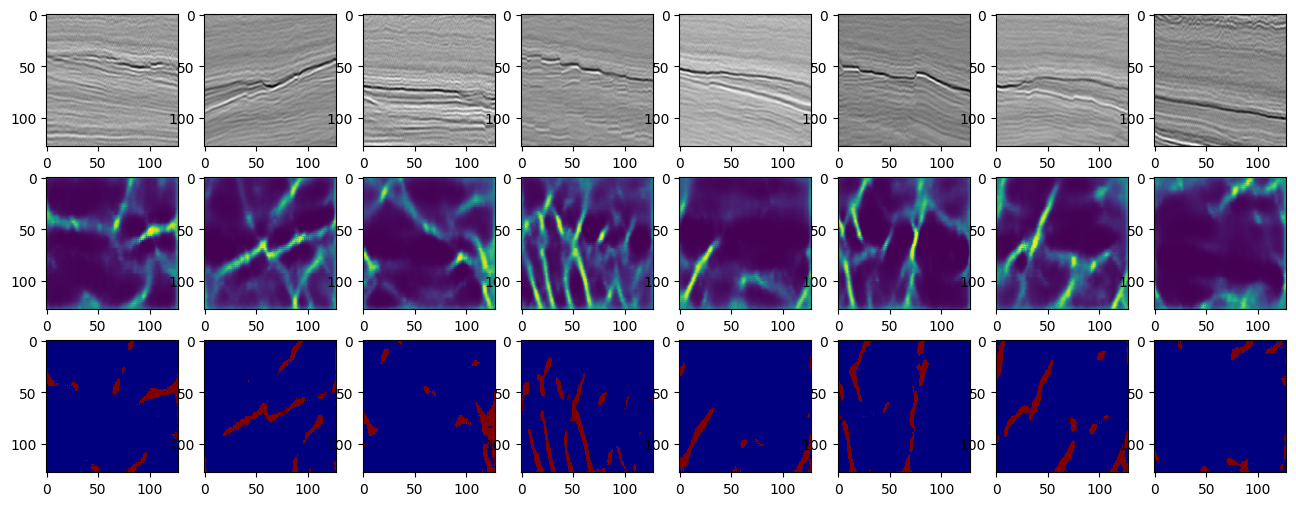

In [23]:
fig, axes = plt.subplots(3, 8, figsize=[16,6])

for i in range(8):
    axes[0, i].imshow(x_tgt[i,0], cmap="gray")
    axes[1, i].imshow(y_tgt_prob[i,0])
    axes[2, i].imshow(y_tgt_pred[i], cmap="jet", interpolation="nearest")
    
# wandb.log({"valid/imgs_tgt": fig})